https://discourse.pymc.io/t/mixed-multivariate-gauss-distribution/1017/

In [1]:
%matplotlib inline
import numpy as np
import numpy as np
import pymc3 as pm
from theano import tensor as tt
import matplotlib.pylab as plt

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
K = 6  # the number of components
N = 200  # the number of observed individuals
n = 9  # each individual was observed 9 times

mu0 = np.linspace(0.0, 0.0, num=n)

# simulate observation data

C1 = np.zeros((n, n))
for i in range(0, n):
    for j in range(0, n):
        if i == j:
            C1[i, j] = 10.0
        else:
            C1[i, j] = 7.0

dataSet1 = np.random.multivariate_normal(mu0, C1, size=N)

# observation time(all individuals are observed at the same times)

time_obseved = [-5.0, -4.5, -3.0, -2.5, -1.0, 0.0, 1.5, 2.5, 3.0, 4.0, 5.5]
time = np.array(time_obseved)

H0 = np.zeros((n, n))
for i in range(0, n):
    for j in range(0, n):
        H0[i, j] = np.abs(time[j] - time[i])


def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1],
                                        tt.extra_ops.cumprod(1 - beta)[:-1]])

    return beta * portion_remaining

In [3]:
with pm.Model() as model:
    M = pm.Gamma('M', 1., 1.)
    sigma_w = pm.Uniform('sigma_w', 0.0, 1.5, shape=K)
    rho = pm.Uniform('rho', 0.0, 0.1, shape=K)

    beta = pm.Beta('beta', 1., M, shape=K)
    w0 =stick_breaking(beta)
    w = pm.Deterministic('w', w0/w0.sum())
    
    compdist = []
    for i in range(K):
        compdist.append(
            pm.MvNormal.dist(mu=mu0, cov=sigma_w[i]**2 * tt.pow(rho[i], H0)))

    obs = pm.Mixture('obs', w, compdist, observed=dataSet1)

In [4]:
# np.sum(w.tag.test_value)

In [5]:
for var in model.basic_RVs:
    print(var.name, var.logp(model.test_point))

M_log__ -1.0
sigma_w_interval__ -8.317766166719343
rho_interval__ -8.317766166719343
beta_logodds__ -8.317766166719343
obs -15844.496465394916


In [23]:
with model:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_logodds__, rho_interval__, sigma_w_interval__, M_log__]
100%|██████████| 1000/1000 [08:38<00:00,  1.93it/s]
There were 98 divergences after tuning. Increase `target_accept` or reparameterize.
There were 150 divergences after tuning. Increase `target_accept` or reparameterize.
There were 134 divergences after tuning. Increase `target_accept` or reparameterize.
There were 92 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9157613243272663, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


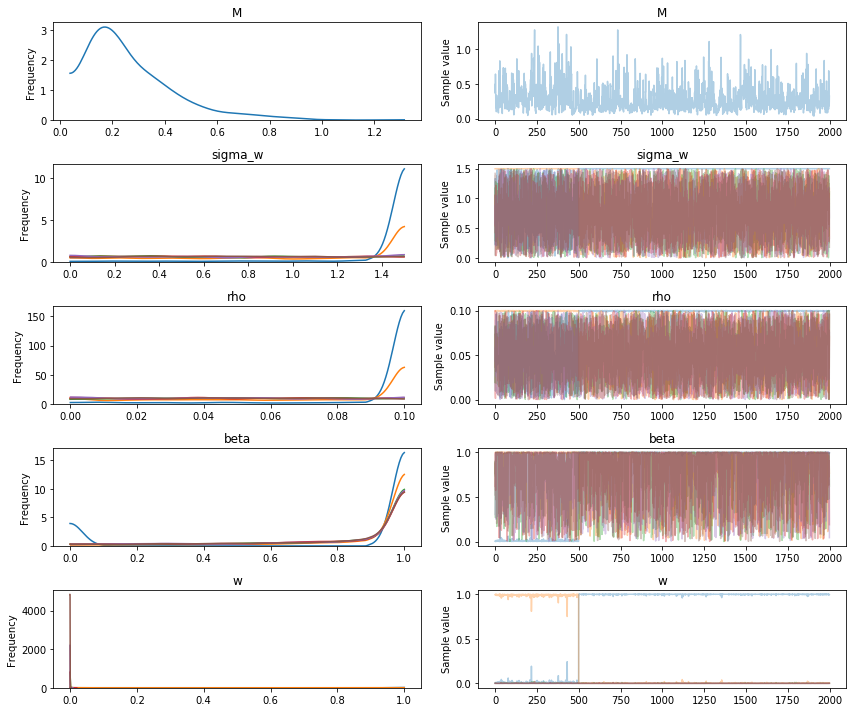

In [25]:
pm.traceplot(trace, combined=True);

In [6]:
K = 6  # the number of mixed components
N = 200  # the number of observed individuals
n = 5  # each individual was observed 5 times

e = np.ones(n)
I = np.eye(n)
mu0 = np.linspace(0.0, 0.0, num=n)

# simulate observation data
C1 = np.zeros((n, n))
for i in range(0, n):
    for j in range(0, n):
        if i == j:
            C1[i, j] = 10.0
        else:
            C1[i, j] = 7.0

dataSet1 = np.random.multivariate_normal(mu0, C1, size=N)

# observation time(all individuals are observed at the same times)
time_obseved = [-4.0, -1.0, 0.0, 1.5, 2.0]
time = np.array(time_obseved)

H0 = np.zeros((n, n))
for i in range(0, n):
    for j in range(0, n):
        H0[i, j] = np.abs(time[j] - time[i])

In [41]:
with pm.Model() as model:
    M = pm.Gamma('M', 1., 1.)

    sigma_w = pm.Uniform('sigma_w', 0.0, 1.5, shape=K)
    rho = pm.Uniform('rho', 0.0, 0.1, shape=K)

    beta = pm.Beta('beta', 1., M, shape=K)
    w0 = stick_breaking(beta)
    w = pm.Deterministic('w', w0 / w0.sum())

    compdist = []
    for i in range(K):
        compdist.append(
            pm.MvNormal.dist(
                mu=mu0, cov=sigma_w[i]**2 * tt.pow(rho[i], H0)))

    # n dimensional random variable omega obeys a multicomponent mixture distribution
    omega = pm.Mixture('omega', w, compdist, shape=dataSet1.shape)

    mu = pm.Normal('mu', mu=0.0, sd=1.0)
    sigma = pm.Uniform('sigma', 0.0, 1.0)
    xi = pm.InverseGamma('xi', 1.0, 1.0)
    b = pm.Normal('b', mu=0.0, sd=tt.sqrt(xi), shape=(N, 1))

    mu2 = (mu + b) * e + omega

    y = pm.Normal(
        'y', mu=mu2, sd=sigma**2,
        observed=dataSet1)  #y_i~N(mu=(mu+b_i)*e+omega_i,cov=sigma**2*I)

In [44]:
with model:
    trace = pm.sample(chains=1)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
INFO:pymc3:Sequential sampling (1 chains in 1 job)
NUTS: [b, xi_log__, sigma_interval__, mu, omega, beta_logodds__, rho_interval__, sigma_w_interval__, M_log__]
INFO:pymc3:NUTS: [b, xi_log__, sigma_interval__, mu, omega, beta_logodds__, rho_interval__, sigma_w_interval__, M_log__]
100%|██████████| 1000/1000 [27:03<00:00,  1.10it/s] 
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.35930091670720254, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks
INFO:pymc3:Only one chain was samp

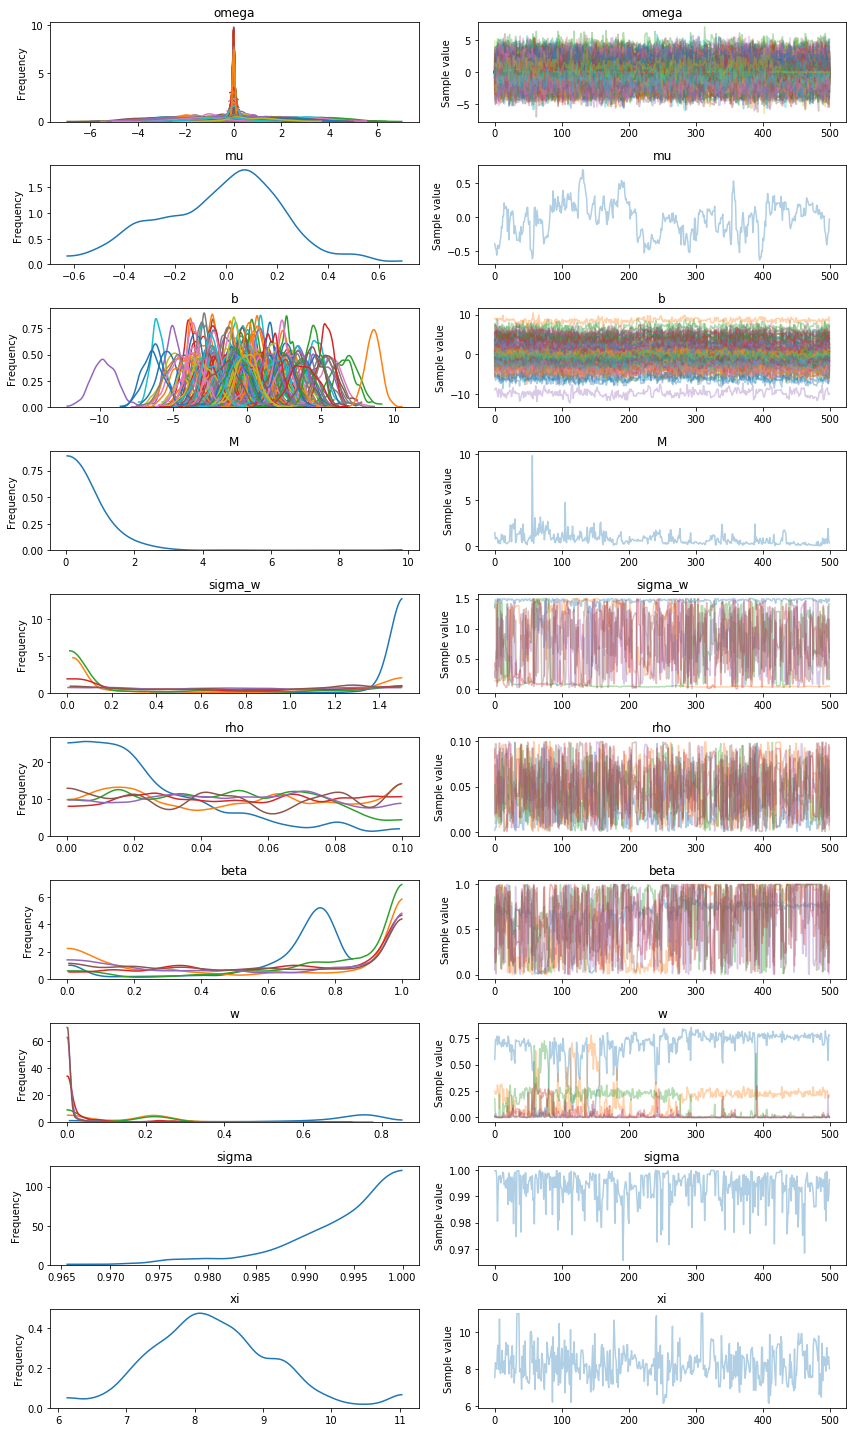

In [45]:
pm.traceplot(trace);